In [42]:
import numpy as np
import matplotlib.pyplot as plt
from triqs.gf import *
import triqs.utility.mpi as mpi
from triqs.gf.descriptors import Function
from triqs.operators import *
from triqs.plot.mpl_interface import oplot
import h5
%config InlineBackend.figure_format = 'retina'

NEW_PATH = "/mnt/home/nkavokine/ctseg_J/build/python/triqs_ctseg/__init__.py"
OLD_PATH = "/mnt/home/nkavokine/ctseg_OLD/build/python/triqs_ctseg/__init__.py"

import importlib
import sys
spec_new = importlib.util.spec_from_file_location("triqs_ctseg_J", NEW_PATH)
ctseg_new = importlib.util.module_from_spec(spec_new)
sys.modules[spec_new.name] = ctseg_new 
spec_new.loader.exec_module(ctseg_new)
spec = importlib.util.spec_from_file_location("triqs_ctseg", OLD_PATH)
ctseg_old = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = ctseg_old 
spec.loader.exec_module(ctseg_old)


Parameters

In [43]:
beta = 20
U    = 1.0
#mu   = 0.0
mu = U/2
epsilon = 0.3
l = 1.0  #electron boson coupling
w0 = 1.0 #screening frequency
n_tau = 20001
n_iw = 10000
random_seed = 23488
length_cycle = 50
n_warmup_cycles = 1000
n_cycles = 100000
measure_gt = True
measure_n = True
measure_nnt = True
move_move = True

has_Dt = False

# Local Hamiltonian
H = U*n("up",0)*n("down",0)

# Hybridization 
delta = GfImFreq(indices=[0], beta=beta, n_points = n_iw) 
delta << inverse(iOmega_n - epsilon) #+ inverse(iOmega_n + epsilon)

Greens Function  with mesh Matsubara Freq Mesh of size 20000, Domain: Matsubara domain with beta = 20, statistic = 1, positive_only : 0 and target_rank 2: 

Setup new solver

In [44]:
# Parameters
p = {}
p["random_seed"] = random_seed
p["length_cycle"] = length_cycle
p["n_warmup_cycles"] = n_warmup_cycles
p["n_cycles"] = n_cycles
p["measure_gt"] = measure_gt
p["measure_n"] = measure_n
p["measure_nnt"] = measure_nnt
p["hartree_shift"] = [mu,mu]

p["move_insert_segment"] = True
p["move_remove_segment"] = True
p["move_split_segment"] = True
p["move_regroup_segment"] = True
p["move_insert_spin_segment"] = False
p["move_remove_spin_segment"] = False
p["move_swap_spin_lines"] = False
p["move_move_segment"] = move_move


# Solver! 
Snew = ctseg_new.SolverCore(beta = beta,
           gf_struct= [['down',1], ['up',1]],
           n_tau = n_tau,
           n_tau_k = n_tau,
           n_tau_jperp = n_tau
           )


Snew.Delta_tau << Fourier(delta); 

if has_Dt:
    D0w = GfImFreq(indices=[0], beta=beta, statistic = 'Boson', n_points = n_iw)
    D0w << Function(lambda w: l**2*2*w0/(w**2-w0**2))
    Snew.D0_tau << Fourier(D0w)


In [45]:
Snew.solve(h_int=H, **p)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┌─┐┌─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗  │   │ └─┐├┤ │ ┬
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ └─┘└─┘└─┘
mu = [0.5,0.5] 
U = 
[[0,1]
 [1,0]]
Dynamical interactions = false, J_perp interactions = false

Warming up ...



Accumulating ...
18:11:49   0% ETA 00:00:17 cycle 579 of 100000
18:11:51  16% ETA 00:00:10 cycle 16573 of 100000
18:11:54  37% ETA 00:00:07 cycle 37332 of 100000
18:11:57  63% ETA 00:00:04 cycle 63339 of 100000
18:12:01  95% ETA 00:00:00 cycle 95819 of 100000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
Density [0.55689,0.558601]
[Rank 0] Timings for all measures:
Measure             | seconds   
Density             | 0.0110558 
G(tau)              | 0.180677  
Perturbation orders | 0.01216   
nn(tau)             | 8.54823   
Total measure time  | 8.75212   
[Rank 0] Acceptance rate for all moves:
Move  insert: 0.38363
Move  remove: 0.383262
Move  move: 0.210609
Move  split: 0.434036
Move  regroup: 0.434701
[Rank 0] Warmup lasted: 0.0619054 

Setup old solver

In [49]:
# Parameters
p = {}
p["random_seed"] = random_seed
p["length_cycle"] = length_cycle
p["n_warmup_cycles"] = n_warmup_cycles
p["n_cycles"] = n_cycles
p["measure_gt"] = measure_gt
p["measure_nnt"] = measure_nnt
p["move_insert_segment"] = True
p["move_remove_segment"] = True
p["move_move"] = move_move
p["hartree_shift"] = [0,0]

gf_struct= [("up",1), ("down",1)]

# Solver! 
Sold = ctseg_old.SolverCore(beta = beta,
           gf_struct= gf_struct,
           n_tau = n_tau,
           n_tau_k = n_tau,
           n_tau_jperp = n_tau,
           n_iw = n_iw
           )

Sold.G0_iw << inverse(iOmega_n + mu - delta); 

if has_Dt:
    for b1 in dict(gf_struct).keys():
        for b2 in dict(gf_struct).keys():
            Sold.D0_iw[b1+"|"+b2] << Function(lambda w: l**2*2*w0/(w**2-w0**2))
            #Sold.Jperp_iw << Function(lambda w: l**2*2*w0/(w**2-w0**2))

In [50]:
Sold.solve(h_int=H, **p)


╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┌─┐┌─┐┌─┐
 ║ ╠╦╝║║═╬╗╚═╗  │   │ └─┐├┤ │ ┬
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ └─┘└─┘└─┘
mu = [0.5,0.5]
U = 
[[0,1]
 [1,0]]


Warming up ...



Accumulating ...
18:13:03   1% ETA 00:00:06 cycle 1459 of 100000
18:13:05  33% ETA 00:00:04 cycle 33335 of 100000
18:13:07  74% ETA 00:00:01 cycle 74310 of 100000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure                    | seconds   
G(tau) measurement         | 0.235442  
measurement of the MC sign | 0.00571305
nn(tau) measurement        | 0.149612  
Total measure time         | 0.390767  
[Rank 0] Acceptance rate for all moves:
Move  segment insertion: 0.661406
Move  segment removal: 0.66169
Move  segment move to another line: 0.109126
[Rank 0] Warmup lasted: 0.0798466 seconds [00:00:00]
[Rank 0] Simulation lasted: 6.24644 seconds [00:00:06]
[Rank 0] Number of measures: 100000
Total number of measures: 100000


Density (new) :  [0.55688971 0.55860071]


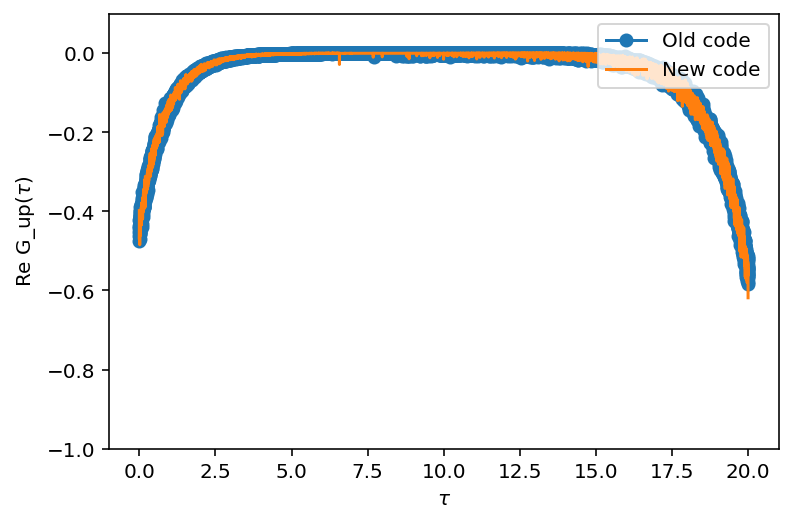

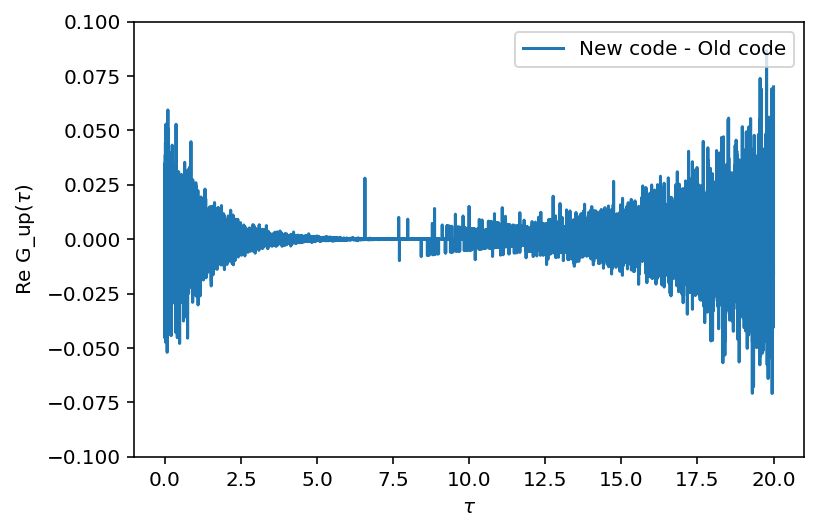

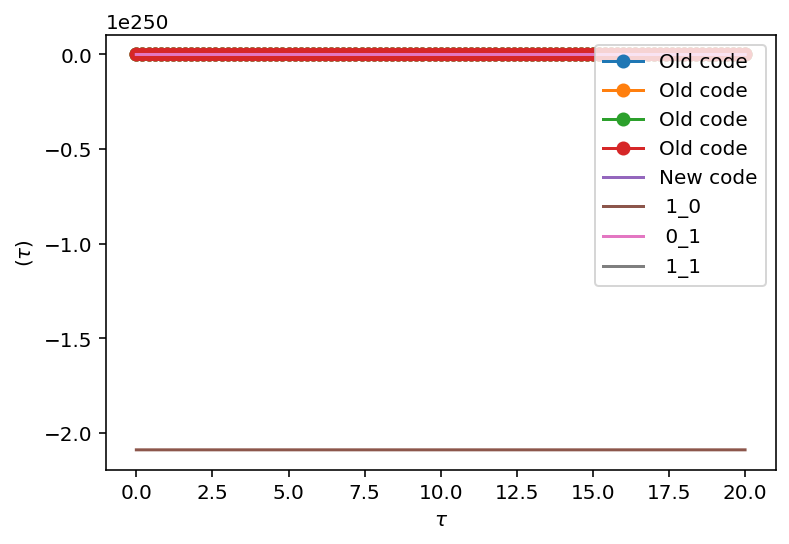

In [52]:
# Non-interacting GF
G0tau = GfImTime(indices=[0], beta=beta, n_points = n_tau) 
G0w = GfImFreq(indices=[0], beta=beta, n_points = n_iw) 
G0w << inverse(iOmega_n + mu - delta)
G0tau << Fourier(G0w)

# Results
Gnew = 0.5*(Snew.results.G_tau['up'].real + Snew.results.G_tau['down'].real)
Gold = 0.5*(Sold.G_tau['up'].real + Sold.G_tau['down'].real)

fig, ax = plt.subplots()
oplot(Gold,'o-',label = "Old code")
oplot(Gnew,label = "New code")
ax.set_ylim([-1,0.1])
#oplot(G0tau.real,'-x',label = "G0")

fig, ax = plt.subplots()
oplot(Gold - Gnew,label = "New code - Old code")
ax.set_ylim([-0.1,0.1])

fig, ax = plt.subplots()
oplot(Sold.nn_tau.real, 'o-', label = "Old code")
oplot(Snew.results.nn_tau.real, label = "New code")


print("Density (new) : ", Snew.results.densities)